In [9]:
import os
from utils import tile_raster_images
from pylearn2.utils import serial
import theano
import theano.tensor as T

try:
    import PIL.Image as Image
except ImportError:
    import Image
import IPython.display as I

#Load models and data

In [2]:
DIR_DATA = '/Users/vmisra/data/AE_experiments'
dir_model = os.path.join(DIR_DATA,'models')
dir_fuel = os.path.join(DIR_DATA,'fuel')

In [3]:
AE_finetuned = serial.load(os.path.join(dir_model,'finetune.pkl'))

In [4]:
test_data = serial.load(os.path.join(dir_fuel,'mnist_test_X.pkl'))

#Define graph

In [5]:
X = AE_finetuned.get_input_space().make_theano_batch()

In [6]:
Y = AE_finetuned.fprop(X)

#Compute output

In [7]:
xhat = Y.eval({X:test_data})

original


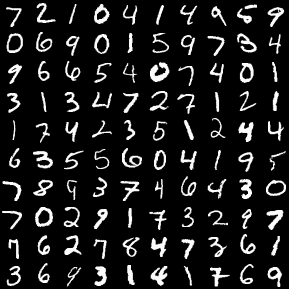

In [11]:
original_img = Image.fromarray(tile_raster_images(X=test_data,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('temp.png')
print 'original'
I.display(I.Image('temp.png'))

original


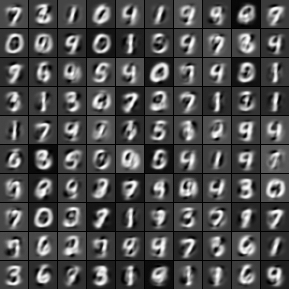

In [12]:
reconstructed = Image.fromarray(tile_raster_images(X=xhat,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
reconstructed.save('temp.png')
print 'original'
I.display(I.Image('temp.png'))